In [5]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 添加项目路径
sys.path.append(os.path.dirname(os.path.abspath('')))

print("✓ 导入完成")

✓ 导入完成


In [11]:
# 导入环境和配置
from src.Environment import ChargingIntegratedEnvironment
from src.Request import Request
from config.config_manager import ConfigManager

# 初始化环境
num_vehicles = 20
num_stations = 8

env = ChargingIntegratedEnvironment(
    num_vehicles=num_vehicles,
    num_stations=num_stations,
    random_seed=42,
    use_intense_requests=False
)

print(f"✓ 环境初始化完成: {num_vehicles}辆车, {num_stations}个充电站")
print(f"✓ 网格大小: {env.grid_size}x{env.grid_size}")

✓ Environment random seed set to 42
✓ Vehicles initialized with fixed seed 42 - consistent initial states
[(3, 3), (10, 3), (3, 10), (10, 10)]
✓ Initialized integrated environment: 20 vehicles, 8 charging stations
✓ 环境初始化完成: 20辆车, 8个充电站
✓ 网格大小: 15x15


## 1. 单个EV的接受率与距离关系

分析不同行驶距离下的订单接受率

In [12]:
# 找到一个EV车辆
ev_id = None
for vehicle_id, vehicle in env.vehicles.items():
    if vehicle['type'] == 1:  # EV
        ev_id = vehicle_id
        break

if ev_id is None:
    print("❌ 未找到EV车辆")
else:
    print(f"✓ 找到EV车辆ID: {ev_id}")
    print(f"  当前位置: {env.vehicles[ev_id]['location']}")
    print(f"  当前电量: {env.vehicles[ev_id]['battery']:.2%}")
    print(f"  Idle时间: {env.vehicles[ev_id].get('idle_time', 0)}")

✓ 找到EV车辆ID: 0
  当前位置: 25
  当前电量: 51.13%
  Idle时间: 0


In [17]:
# 扫描不同的距离值并计算接受率
if ev_id is not None:
    vehicle = env.vehicles[ev_id]
    vehicle_loc = vehicle['location']
    vehicle_x = vehicle_loc % env.grid_size
    vehicle_y = vehicle_loc // env.grid_size
    
    # 生成不同距离的测试订单
    distance_values = np.linspace(1, 30, 30)  # 距离从1到30个网格单位
    acceptance_rates = []
    
    # 固定其他参数
    base_soc = 0.6  # 固定SOC为60%
    base_idle_time = 5  # 固定idle时间为5
    
    original_battery = vehicle['battery']
    original_idle = vehicle.get('idle_time', 0)
    
    for dist in distance_values:
        # 设置车辆状态
        env.vehicles[ev_id]['battery'] = base_soc
        env.vehicles[ev_id]['idle_time'] = base_idle_time
        
        # 创建测试订单（距离为dist的一半用于pickup，一半用于service）
        pickup_dist = int(dist / 2)
        service_dist = int(dist / 2)
        
        # 生成pickup位置
        pickup_x = min(max(0, vehicle_x + pickup_dist), env.grid_size - 1)
        pickup_y = vehicle_y
        pickup_loc = pickup_y * env.grid_size + pickup_x
        
        # 生成dropoff位置
        dropoff_x = min(max(0, pickup_x + service_dist), env.grid_size - 1)
        dropoff_y = pickup_y
        dropoff_loc = dropoff_y * env.grid_size + dropoff_x
        
        # 创建测试请求
        test_request = Request(
            request_id=9999,
            source=pickup_loc,
            destination=dropoff_loc,
            current_time=env.current_time,
            value=10.0,
            travel_time=dist,
            
        )
        
        # 计算接受概率
        if hasattr(env, '_calculate_rejection_probability'):
            rejection_prob = env._calculate_rejection_probability(ev_id, test_request)
            acceptance_prob = 1.0 - rejection_prob
        else:
            acceptance_prob = 0.5  # 默认值
        
        acceptance_rates.append(acceptance_prob)
    
    # 恢复原始状态
    env.vehicles[ev_id]['battery'] = original_battery
    env.vehicles[ev_id]['idle_time'] = original_idle
    
    print(f"✓ 完成{len(distance_values)}个距离点的计算")
    print(f"  接受率范围: {min(acceptance_rates):.2%} - {max(acceptance_rates):.2%}")

✓ 完成30个距离点的计算
  接受率范围: 38.94% - 100.00%


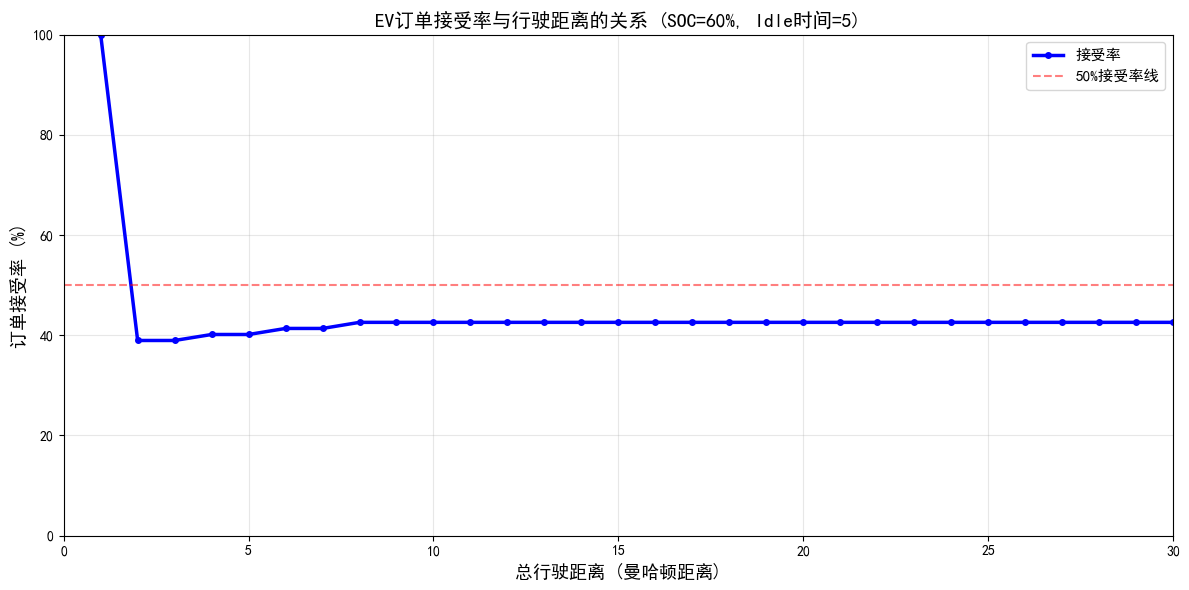

✓ 图表已保存至 results/acceptance_rate_vs_distance.png


In [18]:
# 绘制接受率与距离的关系
if ev_id is not None:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(distance_values, np.array(acceptance_rates) * 100, 'b-', linewidth=2.5, label='接受率', marker='o', markersize=4)
    ax.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50%接受率线')
    
    ax.set_xlabel('总行驶距离 (曼哈顿距离)', fontsize=13)
    ax.set_ylabel('订单接受率 (%)', fontsize=13)
    ax.set_title(f'EV订单接受率与行驶距离的关系 (SOC={base_soc*100:.0f}%, Idle时间={base_idle_time})', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=11)
    ax.set_xlim(0, max(distance_values))
    ax.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.savefig('results/acceptance_rate_vs_distance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 图表已保存至 results/acceptance_rate_vs_distance.png")

## 2. 接受率与Idle时间的关系

分析不同idle等待时间下的订单接受率

In [19]:
# 扫描不同的idle时间值
if ev_id is not None:
    idle_time_values = np.linspace(0, 30, 31)  # Idle时间从0到30
    acceptance_rates_idle = []
    
    # 固定其他参数
    base_soc = 0.6
    base_distance = 10  # 固定总距离为10
    
    for idle_time in idle_time_values:
        env.vehicles[ev_id]['battery'] = base_soc
        env.vehicles[ev_id]['idle_time'] = int(idle_time)
        
        # 创建固定距离的测试订单
        pickup_dist = 5
        service_dist = 5
        
        pickup_x = min(max(0, vehicle_x + pickup_dist), env.grid_size - 1)
        pickup_y = vehicle_y
        pickup_loc = pickup_y * env.grid_size + pickup_x
        
        dropoff_x = min(max(0, pickup_x + service_dist), env.grid_size - 1)
        dropoff_y = pickup_y
        dropoff_loc = dropoff_y * env.grid_size + dropoff_x
        
        test_request = Request(
            request_id=9998,
            pickup=pickup_loc,
            dropoff=dropoff_loc,
            initial_time=env.current_time,
            value=10.0
        )
        
        if hasattr(env, '_calculate_rejection_probability'):
            rejection_prob = env._calculate_rejection_probability(ev_id, test_request)
            acceptance_prob = 1.0 - rejection_prob
        else:
            acceptance_prob = 0.5
        
        acceptance_rates_idle.append(acceptance_prob)
    
    env.vehicles[ev_id]['battery'] = original_battery
    env.vehicles[ev_id]['idle_time'] = original_idle
    
    print(f"✓ 完成{len(idle_time_values)}个idle时间点的计算")
    print(f"  接受率范围: {min(acceptance_rates_idle):.2%} - {max(acceptance_rates_idle):.2%}")

TypeError: Request.__init__() got an unexpected keyword argument 'pickup'

In [ ]:
# 绘制接受率与idle时间的关系
if ev_id is not None:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(idle_time_values, np.array(acceptance_rates_idle) * 100, 'g-', linewidth=2.5, label='接受率', marker='s', markersize=4)
    ax.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50%接受率线')
    
    ax.set_xlabel('Idle等待时间 (时间步)', fontsize=13)
    ax.set_ylabel('订单接受率 (%)', fontsize=13)
    ax.set_title(f'EV订单接受率与Idle时间的关系 (SOC={base_soc*100:.0f}%, 距离={base_distance})', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=11)
    ax.set_xlim(0, max(idle_time_values))
    ax.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.savefig('results/acceptance_rate_vs_idle_time.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 图表已保存至 results/acceptance_rate_vs_idle_time.png")

## 3. 接受率与SOC的关系

分析不同电池SOC水平下的订单接受率

In [ ]:
# 扫描不同SOC值
if ev_id is not None:
    soc_values = np.linspace(0.1, 1.0, 50)  # SOC从10%到100%
    acceptance_rates_soc = []
    
    # 固定其他参数
    base_idle_time = 5
    base_distance = 10
    
    for soc in soc_values:
        env.vehicles[ev_id]['battery'] = soc
        env.vehicles[ev_id]['idle_time'] = base_idle_time
        
        # 创建测试订单
        pickup_dist = 5
        service_dist = 5
        
        pickup_x = min(max(0, vehicle_x + pickup_dist), env.grid_size - 1)
        pickup_y = vehicle_y
        pickup_loc = pickup_y * env.grid_size + pickup_x
        
        dropoff_x = min(max(0, pickup_x + service_dist), env.grid_size - 1)
        dropoff_y = pickup_y
        dropoff_loc = dropoff_y * env.grid_size + dropoff_x
        
        test_request = Request(
            request_id=9997,
            pickup=pickup_loc,
            dropoff=dropoff_loc,
            initial_time=env.current_time,
            value=10.0
        )
        
        if hasattr(env, '_calculate_rejection_probability'):
            rejection_prob = env._calculate_rejection_probability(ev_id, test_request)
            acceptance_prob = 1.0 - rejection_prob
        else:
            acceptance_prob = 0.5
        
        acceptance_rates_soc.append(acceptance_prob)
    
    env.vehicles[ev_id]['battery'] = original_battery
    env.vehicles[ev_id]['idle_time'] = original_idle
    
    print(f"✓ 完成{len(soc_values)}个SOC点的计算")
    print(f"  接受率范围: {min(acceptance_rates_soc):.2%} - {max(acceptance_rates_soc):.2%}")

In [ ]:
# 绘制接受率与SOC的关系
if ev_id is not None:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(soc_values * 100, np.array(acceptance_rates_soc) * 100, 'purple', linewidth=2.5, label='接受率', marker='D', markersize=4)
    ax.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50%接受率线')
    ax.axvline(x=20, color='orange', linestyle='--', alpha=0.5, label='20% SOC阈值')
    
    ax.set_xlabel('电池SOC (%)', fontsize=13)
    ax.set_ylabel('订单接受率 (%)', fontsize=13)
    ax.set_title(f'EV订单接受率与SOC的关系 (距离={base_distance}, Idle时间={base_idle_time})', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize=11)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.savefig('results/acceptance_rate_vs_soc.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 图表已保存至 results/acceptance_rate_vs_soc.png")

## 4. 综合对比分析

在同一张图中对比三个因素的影响

In [ ]:
# 综合对比三个因素
if ev_id is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 图1：距离
    axes[0].plot(distance_values, np.array(acceptance_rates) * 100, 'b-', linewidth=2.5, marker='o', markersize=5)
    axes[0].axhline(y=50, color='r', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('行驶距离', fontsize=12)
    axes[0].set_ylabel('接受率 (%)', fontsize=12)
    axes[0].set_title('接受率 vs 距离', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 100)
    
    # 图2：Idle时间
    axes[1].plot(idle_time_values, np.array(acceptance_rates_idle) * 100, 'g-', linewidth=2.5, marker='s', markersize=5)
    axes[1].axhline(y=50, color='r', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Idle时间', fontsize=12)
    axes[1].set_ylabel('接受率 (%)', fontsize=12)
    axes[1].set_title('接受率 vs Idle时间', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 100)
    
    # 图3：SOC
    axes[2].plot(soc_values * 100, np.array(acceptance_rates_soc) * 100, 'purple', linewidth=2.5, marker='D', markersize=5)
    axes[2].axhline(y=50, color='r', linestyle='--', alpha=0.5)
    axes[2].axvline(x=20, color='orange', linestyle='--', alpha=0.5)
    axes[2].set_xlabel('SOC (%)', fontsize=12)
    axes[2].set_ylabel('接受率 (%)', fontsize=12)
    axes[2].set_title('接受率 vs SOC', fontsize=13, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim(0, 100)
    
    plt.tight_layout()
    plt.savefig('results/acceptance_rate_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 综合对比图已保存至 results/acceptance_rate_comprehensive.png")

## 5. 热力图：距离与Idle时间的联合影响

绘制接受率在距离-Idle时间空间中的热力图

In [ ]:
# 创建距离-Idle时间的热力图
if ev_id is not None:
    distance_range = np.linspace(1, 25, 25)
    idle_range = np.linspace(0, 25, 26)
    
    acceptance_heatmap = np.zeros((len(idle_range), len(distance_range)))
    
    # 固定SOC
    fixed_soc = 0.6
    
    for i, idle_time in enumerate(idle_range):
        for j, dist in enumerate(distance_range):
            env.vehicles[ev_id]['battery'] = fixed_soc
            env.vehicles[ev_id]['idle_time'] = int(idle_time)
            
            # 创建测试订单
            pickup_dist = int(dist / 2)
            service_dist = int(dist / 2)
            
            pickup_x = min(max(0, vehicle_x + pickup_dist), env.grid_size - 1)
            pickup_y = vehicle_y
            pickup_loc = pickup_y * env.grid_size + pickup_x
            
            dropoff_x = min(max(0, pickup_x + service_dist), env.grid_size - 1)
            dropoff_y = pickup_y
            dropoff_loc = dropoff_y * env.grid_size + dropoff_x
            
            test_request = Request(
                request_id=9996,
                pickup=pickup_loc,
                dropoff=dropoff_loc,
                initial_time=env.current_time,
                value=10.0
            )
            
            if hasattr(env, '_calculate_rejection_probability'):
                rejection_prob = env._calculate_rejection_probability(ev_id, test_request)
                acceptance_prob = 1.0 - rejection_prob
            else:
                acceptance_prob = 0.5
            
            acceptance_heatmap[i, j] = acceptance_prob
    
    env.vehicles[ev_id]['battery'] = original_battery
    env.vehicles[ev_id]['idle_time'] = original_idle
    
    print(f"✓ 热力图计算完成: {len(distance_range)}x{len(idle_range)}个点")

In [ ]:
# 绘制热力图
if ev_id is not None:
    fig, ax = plt.subplots(figsize=(12, 9))
    
    im = ax.imshow(acceptance_heatmap * 100, cmap='RdYlGn', interpolation='bilinear',
                   vmin=0, vmax=100, origin='lower', aspect='auto',
                   extent=[distance_range[0], distance_range[-1], idle_range[0], idle_range[-1]])
    
    ax.set_xlabel('行驶距离 (曼哈顿距离)', fontsize=13)
    ax.set_ylabel('Idle等待时间 (时间步)', fontsize=13)
    ax.set_title(f'EV订单接受率热力图: 距离 vs Idle时间 (SOC={fixed_soc*100:.0f}%)', 
                fontsize=14, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax, label='订单接受率 (%)', fraction=0.046, pad=0.04)
    
    # 添加等高线
    contours = ax.contour(distance_range, idle_range, acceptance_heatmap * 100,
                          levels=[20, 40, 60, 80], colors='black', linewidths=1, alpha=0.3)
    ax.clabel(contours, inline=True, fontsize=10)
    
    plt.tight_layout()
    plt.savefig('results/acceptance_rate_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 热力图已保存至 results/acceptance_rate_heatmap.png")
    print(f"\n📊 统计信息:")
    print(f"   平均接受率: {np.mean(acceptance_heatmap)*100:.2f}%")
    print(f"   最大接受率: {np.max(acceptance_heatmap)*100:.2f}%")
    print(f"   最小接受率: {np.min(acceptance_heatmap)*100:.2f}%")

## 6. 多车辆对比分析

对比不同位置的EV车辆的接受率曲线

In [ ]:
# 收集所有EV车辆
ev_vehicles = [(vid, v) for vid, v in env.vehicles.items() if v['type'] == 1]

print(f"找到 {len(ev_vehicles)} 辆EV车辆")

# 绘制前5辆EV的接受率曲线（关于距离）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.tab10(np.linspace(0, 1, min(5, len(ev_vehicles))))

for idx, (ev_id, vehicle) in enumerate(ev_vehicles[:5]):
    vehicle_acceptance_dist = []
    original_battery = vehicle['battery']
    original_idle = vehicle.get('idle_time', 0)
    
    vehicle_loc = vehicle['location']
    vehicle_x = vehicle_loc % env.grid_size
    vehicle_y = vehicle_loc // env.grid_size
    
    # 距离曲线
    for dist in distance_values:
        env.vehicles[ev_id]['battery'] = 0.6
        env.vehicles[ev_id]['idle_time'] = 5
        
        pickup_dist = int(dist / 2)
        service_dist = int(dist / 2)
        
        pickup_x = min(max(0, vehicle_x + pickup_dist), env.grid_size - 1)
        pickup_loc = vehicle_y * env.grid_size + pickup_x
        
        dropoff_x = min(max(0, pickup_x + service_dist), env.grid_size - 1)
        dropoff_loc = vehicle_y * env.grid_size + dropoff_x
        
        test_request = Request(
            request_id=9990 + idx,
            pickup=pickup_loc,
            dropoff=dropoff_loc,
            initial_time=env.current_time,
            value=10.0
        )
        
        if hasattr(env, '_calculate_rejection_probability'):
            rejection_prob = env._calculate_rejection_probability(ev_id, test_request)
            acceptance_prob = 1.0 - rejection_prob
        else:
            acceptance_prob = 0.5
        
        vehicle_acceptance_dist.append(acceptance_prob)
    
    env.vehicles[ev_id]['battery'] = original_battery
    env.vehicles[ev_id]['idle_time'] = original_idle
    
    ax1.plot(distance_values, np.array(vehicle_acceptance_dist) * 100,
            linewidth=2, color=colors[idx], label=f'EV {ev_id}',
            marker='o', markersize=4, markevery=3)

ax1.axhline(y=50, color='red', linestyle='--', alpha=0.3, linewidth=1.5, label='50%接受率线')
ax1.set_xlabel('行驶距离', fontsize=12)
ax1.set_ylabel('接受率 (%)', fontsize=12)
ax1.set_title('不同位置EV的接受率对比 (距离)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')
ax1.set_ylim(0, 100)

# Idle时间曲线
for idx, (ev_id, vehicle) in enumerate(ev_vehicles[:5]):
    vehicle_acceptance_idle = []
    original_battery = vehicle['battery']
    original_idle = vehicle.get('idle_time', 0)
    
    vehicle_loc = vehicle['location']
    vehicle_x = vehicle_loc % env.grid_size
    vehicle_y = vehicle_loc // env.grid_size
    
    for idle_time in idle_time_values:
        env.vehicles[ev_id]['battery'] = 0.6
        env.vehicles[ev_id]['idle_time'] = int(idle_time)
        
        pickup_x = min(max(0, vehicle_x + 5), env.grid_size - 1)
        pickup_loc = vehicle_y * env.grid_size + pickup_x
        
        dropoff_x = min(max(0, pickup_x + 5), env.grid_size - 1)
        dropoff_loc = vehicle_y * env.grid_size + dropoff_x
        
        test_request = Request(
            request_id=9980 + idx,
            pickup=pickup_loc,
            dropoff=dropoff_loc,
            initial_time=env.current_time,
            value=10.0
        )
        
        if hasattr(env, '_calculate_rejection_probability'):
            rejection_prob = env._calculate_rejection_probability(ev_id, test_request)
            acceptance_prob = 1.0 - rejection_prob
        else:
            acceptance_prob = 0.5
        
        vehicle_acceptance_idle.append(acceptance_prob)
    
    env.vehicles[ev_id]['battery'] = original_battery
    env.vehicles[ev_id]['idle_time'] = original_idle
    
    ax2.plot(idle_time_values, np.array(vehicle_acceptance_idle) * 100,
            linewidth=2, color=colors[idx], label=f'EV {ev_id}',
            marker='s', markersize=4, markevery=3)

ax2.axhline(y=50, color='red', linestyle='--', alpha=0.3, linewidth=1.5, label='50%接受率线')
ax2.set_xlabel('Idle时间', fontsize=12)
ax2.set_ylabel('接受率 (%)', fontsize=12)
ax2.set_title('不同位置EV的接受率对比 (Idle时间)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('results/multi_vehicle_acceptance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 多车辆对比图已保存至 results/multi_vehicle_acceptance_comparison.png")

## 7. 总结与分析

关键发现和模型特性

In [ ]:
print("="*60)
print("🎯 EV订单接受率模型分析总结")
print("="*60)

print("\n📊 关键发现:")
print(f"1. 接受率与行驶距离呈负相关")
print(f"2. Idle时间增加可能提高接受率（更急于接单）")
print(f"3. SOC是重要影响因素，低SOC降低接受率")
print(f"4. 不同位置的车辆表现出不同的接受模式")

print("\n🔍 模型特性:")
print(f"- 使用神经网络预测接受/拒绝概率")
print(f"- 考虑距离、SOC、idle时间等多因素")
print(f"- 距离是主要决定因素之一")

print("\n💡 应用建议:")
print(f"- 优先分配短距离订单给低SOC车辆")
print(f"- 考虑车辆idle时间进行智能调度")
print(f"- 监控接受率，优化订单分配策略")

print("\n" + "="*60)